In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit


# Advection-Diffusion linéaires:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = \epsilon \frac{\partial^2 u}{\partial x^2} \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

In [27]:
" **** Solutions initiales proposées **** "


@njit(cache=True)
def u0_Creno(x,N,l,L):
    # Fonction indicatrice pour une condition initiale creno
    if  x >= l + 0.25 * (L - l) - 0.1 * (L - l) and x <= l + 0.25 * (L - l):
        return 10.
    else:
        return 0.

@njit(cache=True)
def u0_Gauss(x,N):
    # Condition initiale gaussienne
    return np.sin(np.pi * x / (L - l)) + 2.5 * (L - l) * np.sin((N-1) * (L - l) * np.pi * x / (L - l))


" **** Le flux exact **** "

@njit(cache=True)
def F(u, a):
    # Flux exact
    return a * u


" **** Les flux numériques proposés **** "

@njit(cache=True)
def Rusanov(ug, ud, a, dx, dt):
    # Flux numérique Rusanov
    return 0.5 * (F(ug, a) + F(ud, a)) - a * (ud - ug)

@njit(cache=True)
def Rusanov2(ug, ud, a, dx, dt):
    # Deuxième version du flux numérique Rusanov
    return 0.5 * (F(ug, a) + F(ud, a) - a * (ud - ug))

@njit(cache=True)
def Roe(ug, ud, a, dx, dt):
    # Flux numérique Roe
    if a >= 0:
        return F(ug, a)
    else:
        return F(ud, a)

@njit(cache=True)
def LF(ug, ud, a, dx, dt):
    # Flux numérique Lax-Friedrichs
    return 0.5 * (F(ug, a) + F(ud, a) - (dx / dt) * (ud - ug))

@njit(cache=True)
def LFM(ug, ud, a, dx, dt):
    # Flux numérique Lax-Friedrichs modifié
    return 0.5 * (F(ug, a) + F(ud, a) - 0.5 * (dx / dt) * (ud - ug))

@njit(cache=True)
def LW(ug, ud, a, dx, dt):
    # Flux numérique Lax-Wendroff
    return 0.5 * (F(ug, a) + F(ud, a) - (dt / dx) * (a ** 2) * (ud - ug))

@njit(cache=True)
def VFD(ug, ud, a, dx, dt):
    # Flux numérique volume finis decentré
    if a > 0:
        return F(ug, a)
    else:
        return F(ud, a)

@njit(cache=True)
def VFC(ug, ud, a, dx, dt):
    # Flux numérique volume finis carachtéristiques
    return F(0.5 * (ug + ud) - alpha * (dt / dx) * a * (ud - ug), a)


In [28]:
@njit#(cache=True)
def LinearAdvectionSolver(U0, T, l, L, a, epsilon, N, dt, scheme):

    if scheme == 0:
        flux = Roe 
    elif scheme == 1:
        flux = Rusanov
    elif scheme == 2:
        flux = Rusanov2
    elif scheme == 3:
        flux = LF
    elif scheme == 4:
        flux = LFM
    elif scheme == 5:
        flux = LW
    elif scheme == 6:
        flux = VFD
    elif scheme == 7:
        flux = VFC
    
    Un   = U0.copy()
    Unp1 = np.zeros(N)

    temps = 0
    while temps < T:
        dt = min(dt, T - temps)
        temps += dt

        for i in range(1, N - 1):
            Fd = flux ( Un[i], Un[i + 1], a, dx, dt )
            Fg = flux ( Un[i - 1], Un[i], a, dx, dt )

            Unp1[i] = Un[i] - dt / dx * (Fd - Fg) + epsilon * (dt / (dx**2)) * (Un[i + 1] - 2 * Un[i] + Un[i - 1])

        Unp1[0] = 0#Unp1[1]
        Unp1[N - 1] = 0#Unp1[N - 2]

        Un[:] = Unp1[:]

    return Un


In [46]:
" **** Initialisation des paramètres **** "
T        =  1/8
l        =  0
L        =  1
a        =  2
epsilon  =  0.001
N        =  201
CFL      =  0.5
alpha    =  0.7
X        =  np.linspace(l,L,N)
U0       =  np.array([u0_Creno(x,N,l,L) for x in X])

dx = (L - l) / (N - 1)
if epsilon != 0 and a!=0:
    dt  = CFL /(np.abs(a)/dx + 2 * np.abs(epsilon)/(dx**2))
else:
    if epsilon == 0:
        dt  = CFL *(dx / np.abs(a))
    elif a == 0:
        dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)


f = {}

" **** Calcul des solutions approchées **** "
fluxes = {("Roe",0):1, ("Rusanov",1):1, ("Rusanov2",2):1, ("LF",3):1, ("LFM",4):1, ("LW",5):1, ("VFD",6):1, ("VFC",7):1}

for i,j in fluxes.items():  
    if j:
        f[i[0]]  =  LinearAdvectionSolver  (U0 , T, l, L, a, epsilon, N, dt, i[1])   
    


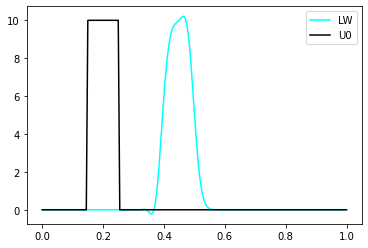

In [47]:
PLOT = {"Roe":0, "Rusanov":0, "Rusanov2":0, "LF":0, "LFM":0, "LW":1, "VFD":0, "VFC":0 }

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']

for i, (flux, Un) in enumerate(f.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, '-', label=flux, color=colors[i])
    
plt.plot(X, U0, '-k',  label='U0')

#plt.xlim([0.3, 0.6])  
#plt.ylim([4, 8])  

plt.legend()
plt.pause(0.1)


In [23]:
Norm = {}
for i, (flux, Un) in enumerate(f.items()):
    Norm[flux]    =  np.linalg.norm(Un,ord = 2) 
Norm

{'Roe': 30.642594885186003,
 'Rusanov': 28.816576966038166,
 'Rusanov2': 30.642594885186,
 'LF': 2.1036520624929315e+60,
 'LFM': 28.81657696603817,
 'LW': 32.52015878619169,
 'VFD': 30.642594885186003,
 'VFC': 32.23614579184689}

# Equation de Burgers avec Diffusion:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \epsilon \frac{\partial^2 u}{\partial x^2} \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

In [18]:
" **** Solutions initiales proposées **** "

@njit
def u0(x):
    #Chock & Détente
    if x <= 1 / 4:
        return ul
    if 1 / 4 < x < 3 / 4:
        return um
    else:
        return ur

@njit
def u0_Gauss(x):
    # Condition initiale gaussienne
    return np.sin(np.pi * x / (L - l)) + 2.5 * (L - l) * np.sin(100 * (L - l) * np.pi * x / (L - l))


" **** Le flux exact **** "
@njit
def F(u):
    return (u**2) / 2

" **** Les flx numériques proposés **** "
@njit
def Rusanov(ug, ud, dx, dt):
    # Flux numérique Rusanov
    lamda = max(abs(ug), abs(ud))
    return 0.5 * (F(ug) + F(ud)) - lamda * (ud - ug)

@njit
def Rusanov2(ug, ud, dx, dt):
    # Deuxième version du flux numérique Rusanov
    lamda = max(abs(ug), abs(ud))
    return 0.5 * (F(ug) + F(ud) - lamda * (ud - ug))

@njit
def Roe(ug, ud, dx, dt):
    # Flux numérique Roe
    return 0.5 * ((F(ug) + F(ud)) - (ug + ud) / 2 * (ud - ug))

@njit
def LF(ug, ud, dx, dt):
    # Flux numérique Lax-Friedrichs
    return 0.5 * ((F(ug) + F(ud)) - (dx / dt) * (ud - ug))

@njit
def LFM(ug, ud, dx, dt):
    # Flux numérique Lax-Friedrichs modifié
    return 0.5 * ((F(ug) + F(ud)) - 0.5 * (dx / dt) * (ud - ug))

@njit
def LW(ug, ud, dx, dt):
    # Flux numérique Lax-Wendroff
    A = 0.5 * (ud + ug)
    return 0.5 * (F(ug) + F(ud) - (dt / dx) * A * (F(ud) - F(ug)))

@njit
def VFC(ug, ud, dx, dt):
    # Flux numérique VFC
    return F(0.5 * (ug + ud) - alpha * (dt / dx) * (F(ud) - F(ug)))


In [19]:
@njit
def NonLinearBurgerSolver(U0, epsilon, T, l, L, N, CFL1, CFL2, dt2, scheme):

    if scheme == 0:
        flux = Roe 
    elif scheme == 1:
        flux = Rusanov
    elif scheme == 2:
        flux = Rusanov2
    elif scheme == 3:
        flux = LF
    elif scheme == 4:
        flux = LFM
    elif scheme == 5:
        flux = LW
    elif scheme == 6:
        flux = VFC
        
    Un   = U0.copy()
    Unp1 = np.zeros(N)

    temps = 0
    while temps < T:
        dt1 = CFL1 * dx / max(np.abs(Un))
        dt = min(dt1, dt2)
        
        dt = min(dt, T - temps)
        temps += dt
        
        for i in range(1,N-1):
            Fd = flux(Un[i],Un[i+1],dx,dt)
            Fg = flux(Un[i-1],Un[i],dx,dt)
            Unp1[i] = Un[i]-dt/dx*(Fd-Fg)+ epsilon * dt / (dx**2) * (Un[i+1] - 2 * Un[i] + Un[i-1])

        Unp1[0] = Unp1[1]
        Unp1[N-1] = Unp1[N-2]


        Un[:] = Unp1[:]
        

    return Un




In [22]:
 " **** Initialization des paramètres **** "

ul       =   0.2
um       =   0.8
ur       =   0.4
T        =   0.2
l        =   0
L        =   1
epsilon  =   1e-2
alpha    =   1
N        =   401
CFL1     =   0.5
CFL2     =   0.5
X        =   np.linspace(l,L,N)
U0       =   np.array([u0(x) for x in X]) 


dx = (L - l) / (N - 1)


if epsilon != 0:
    dt2 = 0.5 * CFL2 * dx**2 / abs(epsilon)
else:
    dt2 = T



" **** Calcul des solutions approchées **** "

f = {}

fluxes = {("Roe",0):1, ("Rusanov",1):1, ("Rusanov2",2):1, ("LF",3):1, ("LFM",4):1, ("LW",5):1, ("VFC",6):1}

for i,j in fluxes.items():  
    if j:
        f[i[0]]  =  NonLinearBurgerSolver  (U0, epsilon, T, l, L, N, CFL1, CFL2, dt2, i[1])   
    


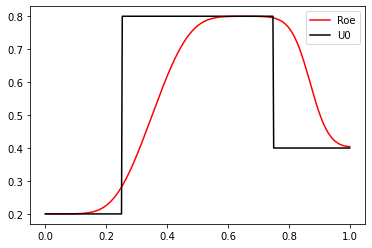

In [23]:
PLOT = {"Roe":1, "Rusanov":0, "Rusanov2":0, "LF":0, "LFM":0, "LW":0, "VFC":0}

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']

for i, (flux, Un) in enumerate(f.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, '-', label=flux, color=colors[i])
    
plt.plot(X, U0, '-k',  label='U0')

#plt.xlim([0.3, 0.5])  
#plt.ylim([6, 12])  

plt.legend()
plt.pause(0.1)
